In [2]:

import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.colors as mcolors
import pySTIM as pst

import warnings
warnings.filterwarnings('ignore')
cmap = mcolors.LinearSegmentedColormap.from_list('WhRd',['#ffffff', "#fffacd", "red", "darkred"], N=256)  

In [3]:
adata = sc.read_h5ad("../Xenium_all.h5ad")

prepare single-cell data (GSE139107) for benchmarking deconvolution

In [37]:
meta = pd.read_table("sc_counts/meta_data.csv.gz")

In [55]:
set(meta['Group'])

{'12hours', '14days', '2days', '4hours', '6weeks', 'Control'}

In [56]:
groups = ["Control", '4hours', '12hours', '2days', '14days', '6weeks']

def process_group(group):
    print(group)

    chunks = pd.read_table(f"sc_counts/{group}_count.dge.txt.gz",index_col=0,chunksize=1000000)
    rna_data = pd.concat(chunks)
    
    meta_group = meta[(meta['Group'] == group)]
    
    rna_group_data = rna_data[meta_group.index.tolist()]
    gene_count = np.sum(rna_group_data > 0, axis=1)
    rna_group_data = rna_group_data.loc[gene_count >= 10, :]
    
    rna_ad = anndata.AnnData(csr_matrix(rna_data.T, dtype=np.float32), obs=meta_group)
    rna_ad.var_names = list(rna_data.index)
    rna_ad.obs_names_make_unique()
    rna_ad.var_names_make_unique()
    
    # Update cell types
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype"]
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['CTAL1', 'CTAL2', 'MTAL'], "TAL")
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['CNT', 'DCT-CNT'], "CNT")
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['EC1', 'EC2'], "EC")
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['PC1', 'PC2'], "PC")
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['NewPT1'], "Inj_PT")
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['NewPT2'], "FR_PT")
    rna_ad.obs["celltype_new"] = rna_ad.obs["celltype_new"].replace(['Mø', 'Tcell'], "Immune")

    rna_ad.write_h5ad(f"Visium_decov_sc_{group}.h5ad")

for group in groups:
    process_group(group)

Control
4hours
12hours
2days
14days
6weeks


In [156]:
algorithm_names = ['tacco', 'Tangram', 'CARD', 'RCTD','cell2location']
ident_list = ["ShamR", "Hour4R", "Hour12R", "Day2R", "Day14R", "Week6R"]
celltypes = ['PTS1', 'Fib', 'EC', 'Pod', 'PC', 'Per', 'PEC', 'Uro', 'ICB', 'ICA',
           'CNT', 'DCT', 'TAL', 'DTL', 'FR_PT', 'Inj_PT', 'PTS3', 'PTS2',
           'Immune']

In [157]:
ground_truth = pd.read_csv(f'deconv_results/xenium_deconv_{ident}.csv', index_col=0)
ground_truth.columns

Index(['PTS1', 'Fib', 'EC', 'Pod', 'PC', 'Per', 'PEC', 'Uro', 'ICB', 'ICA',
       'CNT', 'DCT', 'TAL', 'DTL', 'FR_PT', 'Inj_PT', 'PTS3', 'PTS2',
       'Immune'],
      dtype='object')

In [162]:
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
from scipy.stats import pearsonr

def kl_divergence(p, q):
    p = np.where(p == 0, 1e-10, p)
    q = np.where(q == 0, 1e-10, q)
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return np.sqrt(0.5 * (kl_divergence(p, m) + kl_divergence(q, m)))
    
results = []

for ident in ident_list:
    print(ident)
    ground_truth_file = f'deconv_results/xenium_deconv_{ident}.csv'
    ground_truth = pd.read_csv(ground_truth_file, index_col=0)

    for algorithm in algorithm_names:
        prediction_file = f'deconv_results/{algorithm}_deconv_{ident}.csv'
        prediction = pd.read_csv(prediction_file, index_col=0)
        prediction = prediction[celltypes]
        
        rmse_values = []
        jsd_values = []
        pcc_values = []
        
        for index, row in ground_truth.iterrows():
            gt_values = row.values
            pred_values = prediction.loc[index].values
            
            # RMSE
            rmse = np.sqrt(mean_squared_error(gt_values, pred_values))
            
            # JS Divergence
            jsd = js_divergence(gt_values, pred_values)
            
            # Pearson Correlation Coefficient
            pcc, _ = pearsonr(gt_values, pred_values)
            
        results.append({
            'Algorithm': algorithm,
            'Ident': ident,
            'RMSE': np.median(rmse),
            'JS_Divergence': np.median(jsd),
            'Pearson_Correlation': np.median(pcc)
        })

ShamR
Hour4R
Hour12R
Day2R
Day14R
Week6R


In [163]:
results_df = pd.DataFrame(results)
results_df = results_df[['Algorithm', 'Ident','RMSE', 'JS_Divergence', 'Pearson_Correlation']]
df_long = pd.melt(results_df, id_vars=['Algorithm', 'Ident'], 
                  value_vars=['RMSE', 'JS_Divergence', 'Pearson_Correlation'], 
                  var_name='Metric', value_name='Value')

In [167]:
df_long['Algorithm'] = df_long['Algorithm'].astype('category')
df_long['Algorithm'] = df_long['Algorithm'].cat.reorder_categories(['tacco', 'CARD', 'cell2location', 'Tangram', 'RCTD'])

In [172]:
df_long['Metric'] = df_long['Metric'].replace('Pearson_Correlation','PCC')
df_long['Metric'] = df_long['Metric'].replace('JS_Divergence','JSD')

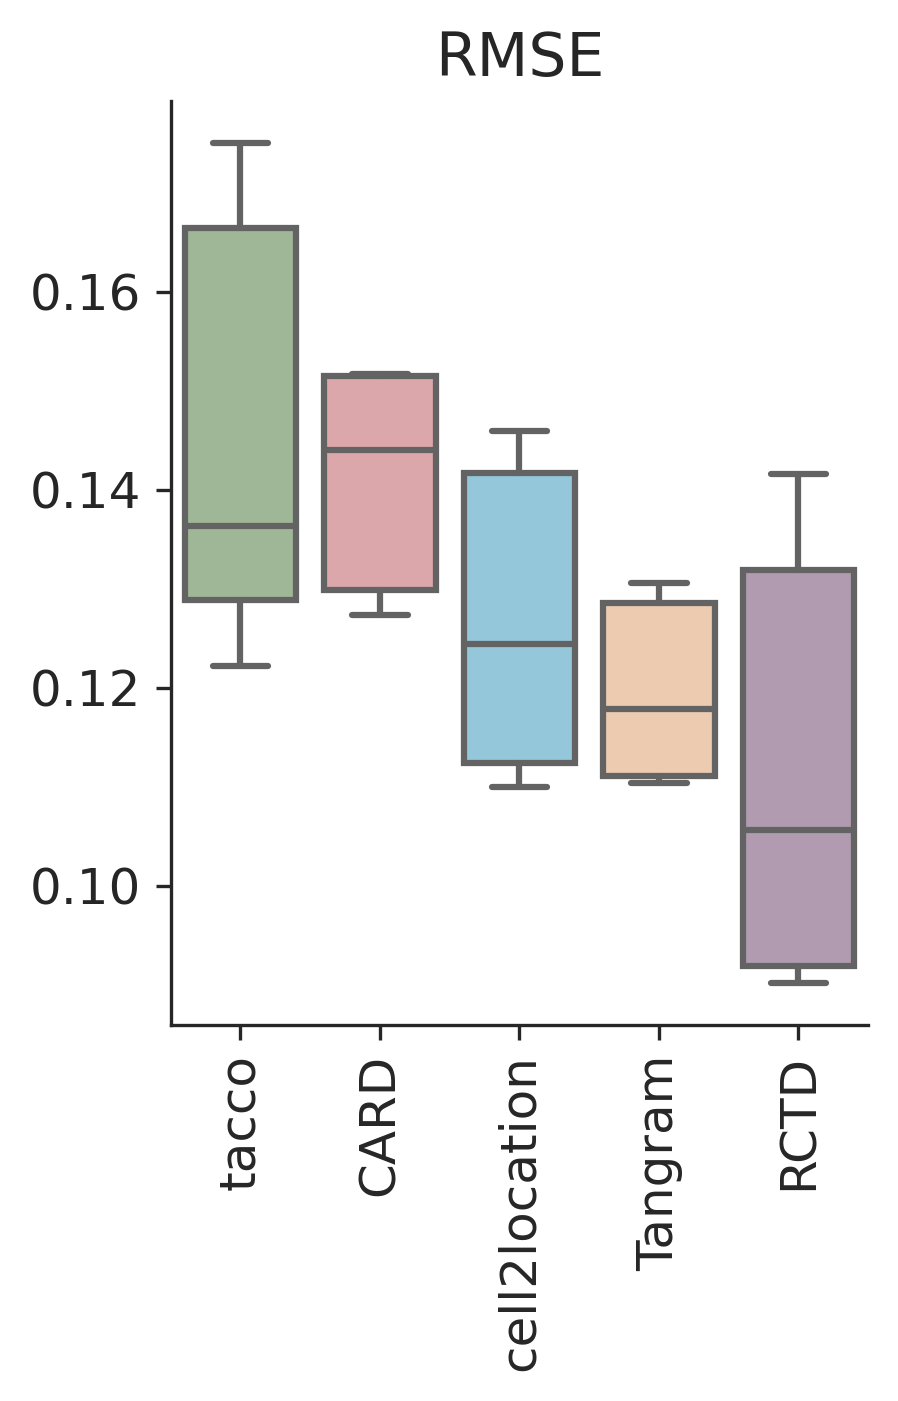

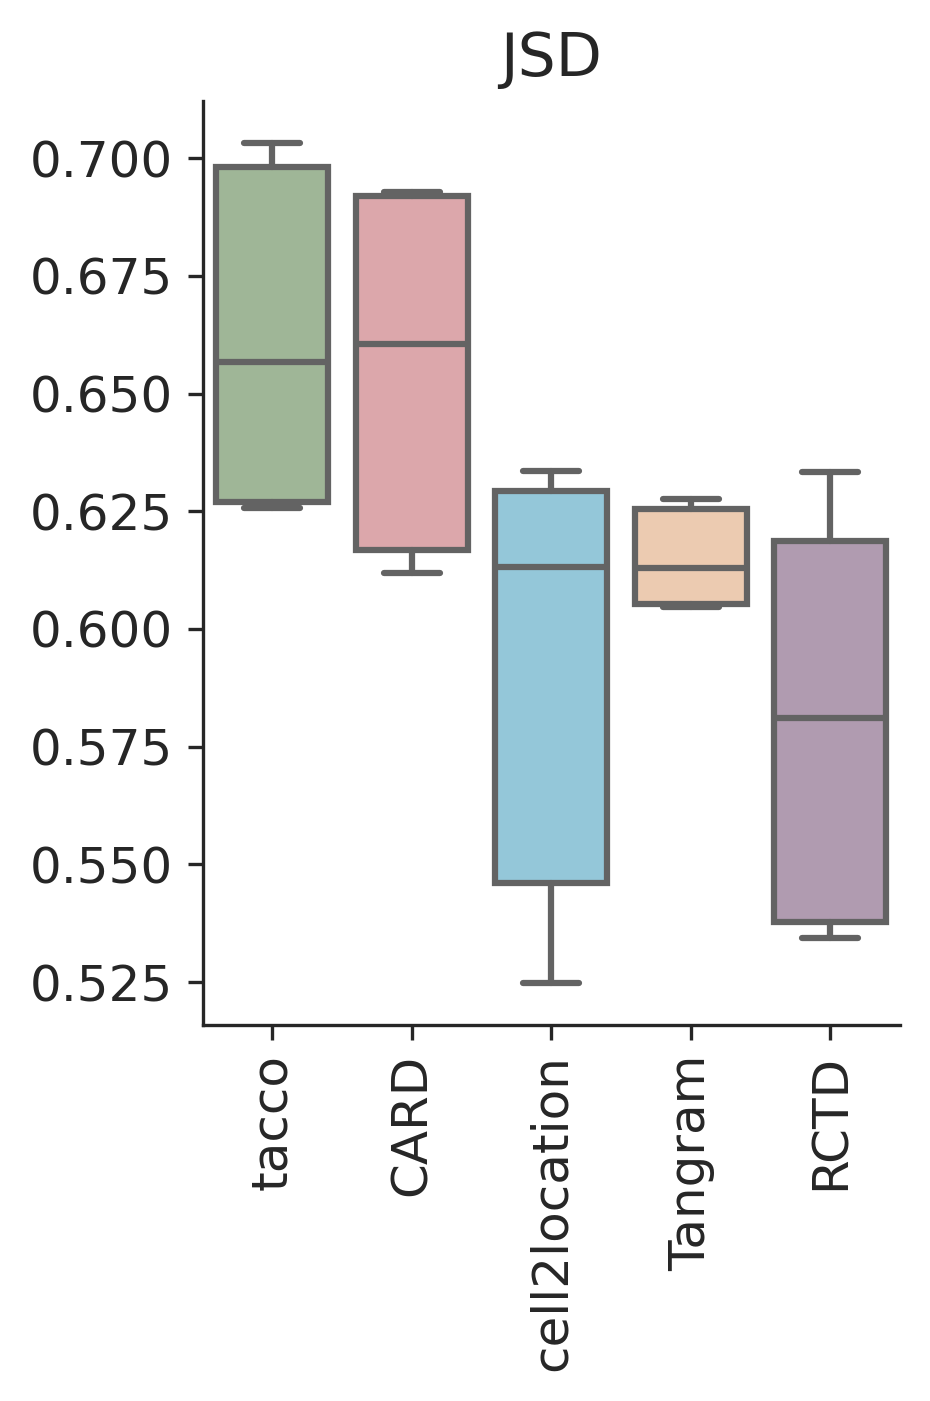

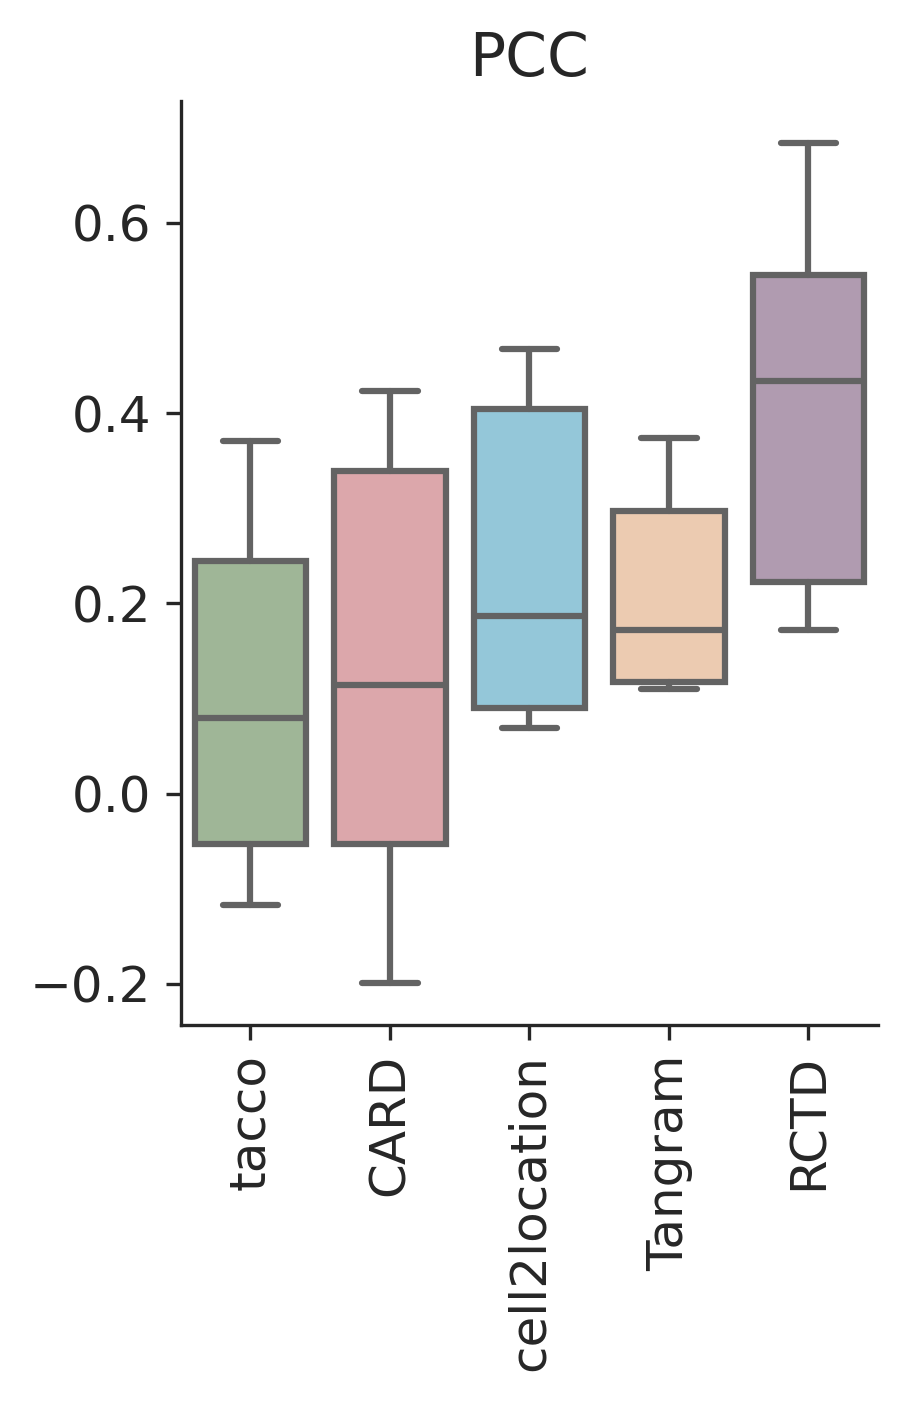

In [182]:
import seaborn as sns

font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 12}
plt.rc('font', **font) 

palette = {'tacco': '#9cbb92',  
           'Tangram': '#f6caa7',  
           'cell2location': '#88cde5',  
           'CARD': '#e59ea3',
           'RCTD': '#b497b3'}  

for metric in df_long['Metric'].unique():
    fig, ax = plt.subplots(figsize=(3, 4), dpi = 300)
    subset = df_long[df_long['Metric'] == metric]
    sns.boxplot(x='Algorithm', y='Value', data=subset, fliersize=1, showcaps = True,whis = 0.5 ,showfliers = False, palette=palette)
    plt.title(f'{metric}')
    plt.xlabel('')
    plt.ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(rotation=90)
    plt.savefig(f"Deconv_algorithm_{metric}.png", transparent=True, bbox_inches='tight')
    plt.show()

In [174]:
ident_list = ["ShamR","Hour4R","Hour12R","Day2R","Day14R","Week6R"]

result_dict = {}
for ident in ident_list:
    correlations = {}
    for algorithm in algorithm_names:
        deconv_df = pd.read_csv(f'deconv_results/{algorithm}_deconv_{ident}.csv', index_col=0)
        xenium_agg_df = pd.read_csv(f'deconv_results/xenium_deconv_{ident}.csv', index_col=0)
        deconv_df = deconv_df[xenium_agg_df.columns]
    
        pcc_list = []
        for column in xenium_agg_df.columns:
            p = xenium_agg_df[column].values + 1e-10
            q = deconv_df[column].values + 1e-10
            
            pcc, _ = stats.pearsonr(p, q)
            pcc_list.append(pcc)
    
        correlations[algorithm] = pcc_list
        
    result_df = pd.DataFrame(correlations, index = xenium_agg_df.columns)
    result_dict[ident] = result_df

In [175]:
hex_colors = ['#8dd3c7', '#bebada', '#80b1d3', '#fccde5', '#ffed6f']

In [176]:
celltype_order = ['PTS3', 'TAL', 'PTS2', 'PTS1', 'Uro', 'ICB', 'DTL', 'CNT', 'DCT', 'PC',
       'Pod', 'Fib', 'Per', 'ICA', 'EC', 'PEC', 'FR_PT', 'Inj_PT', 'Immune']

In [184]:
hex_colors = ['#9cbb92','#f6caa7', '#e59ea3','#b497b3','#88cde5']

ShamR


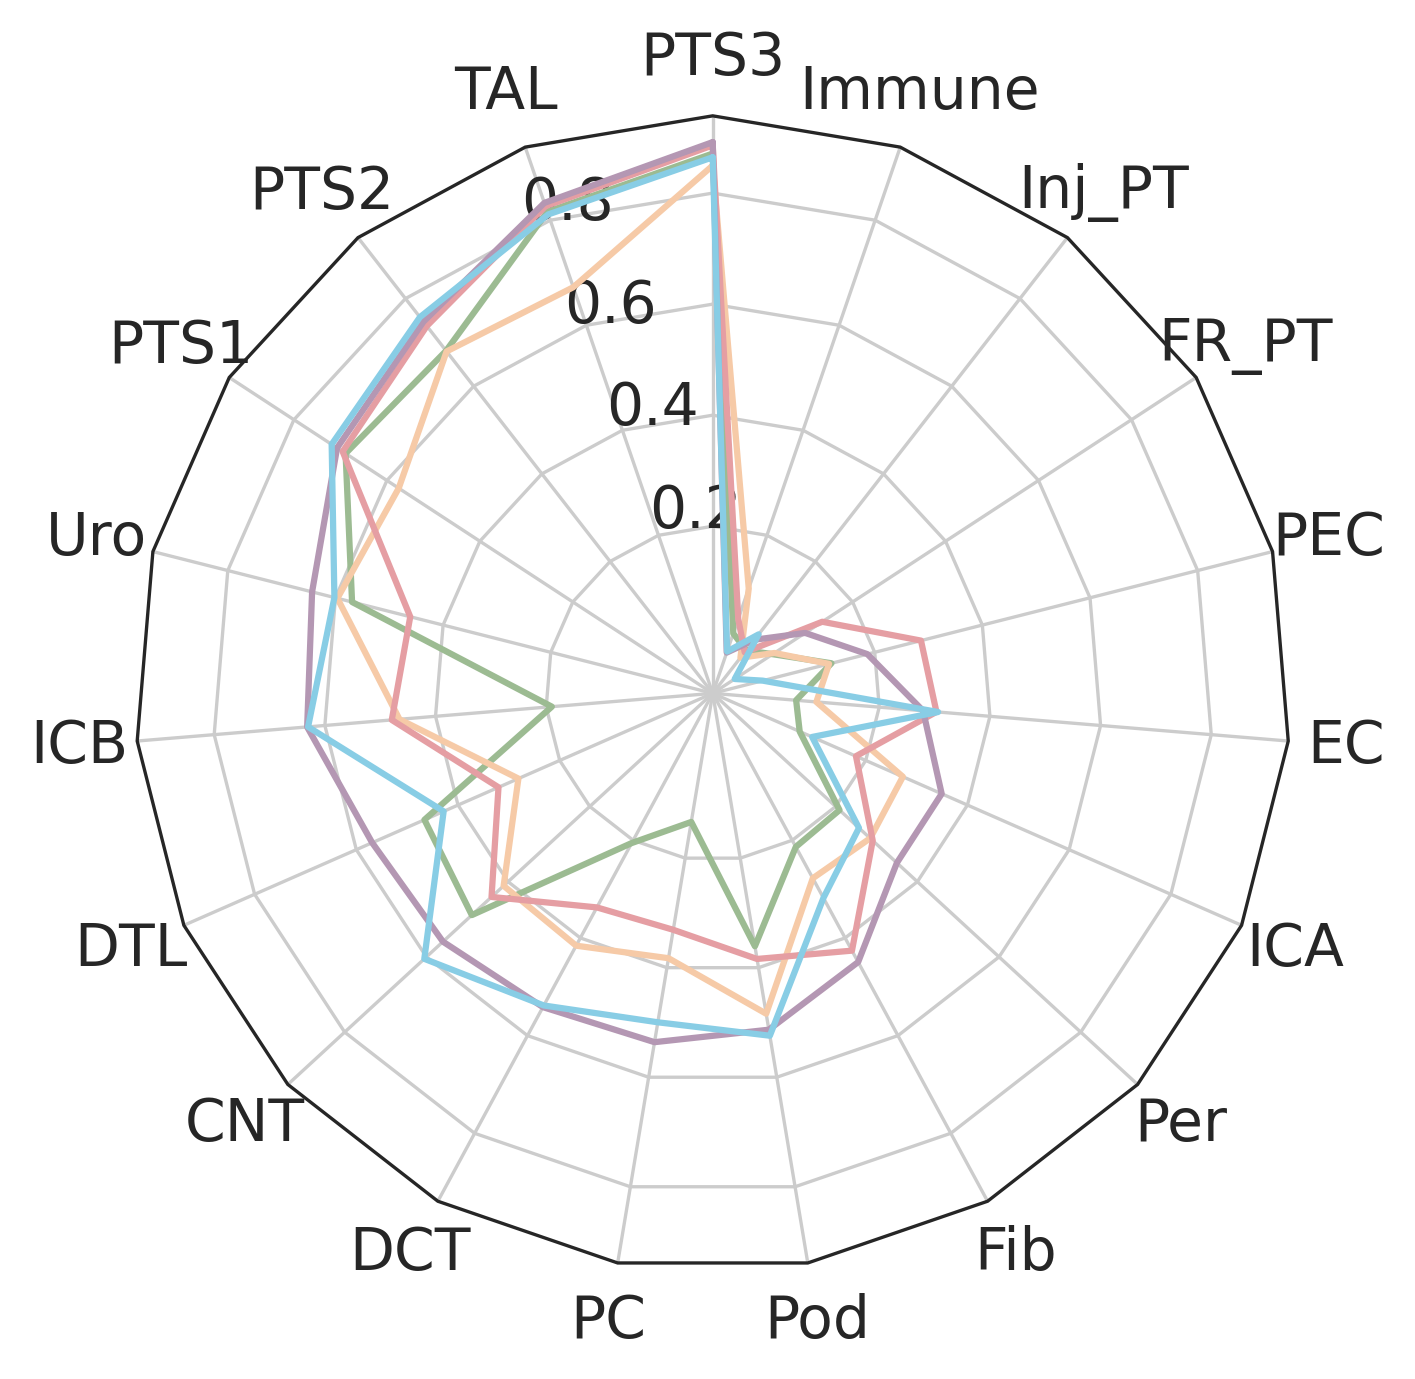

Hour4R


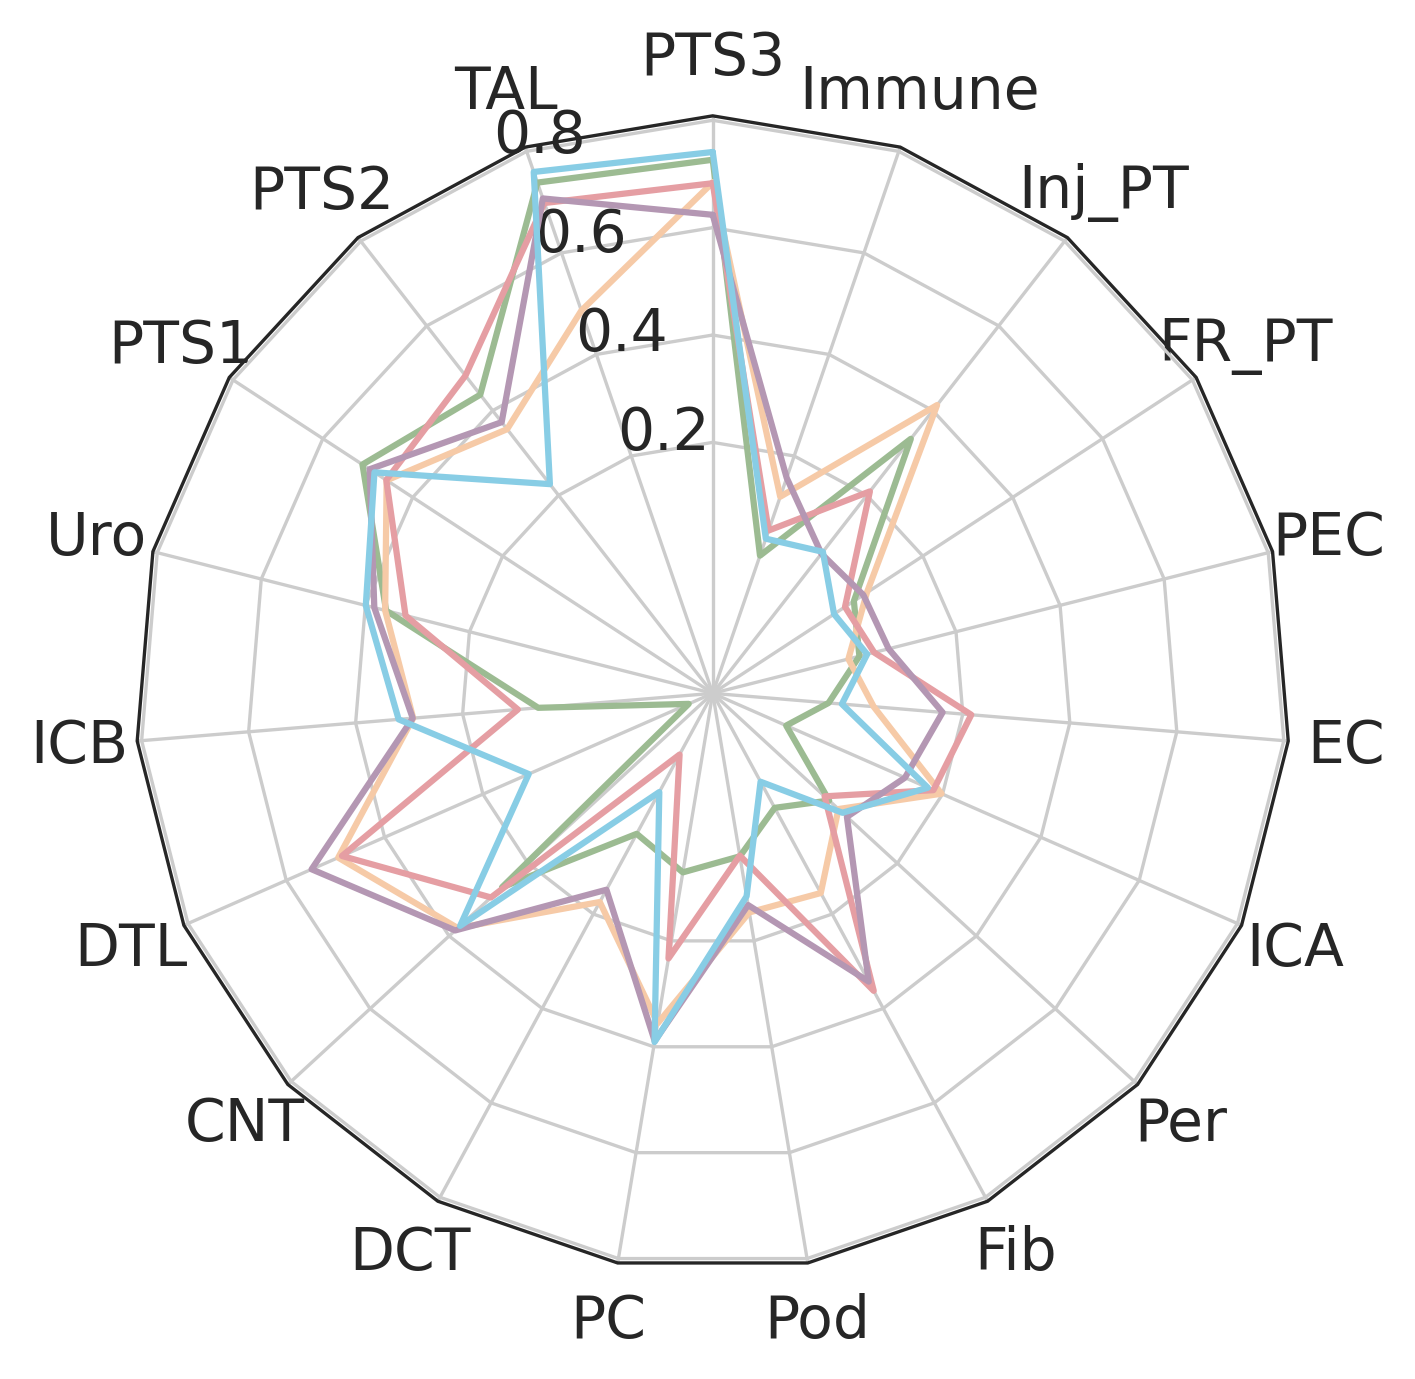

Hour12R


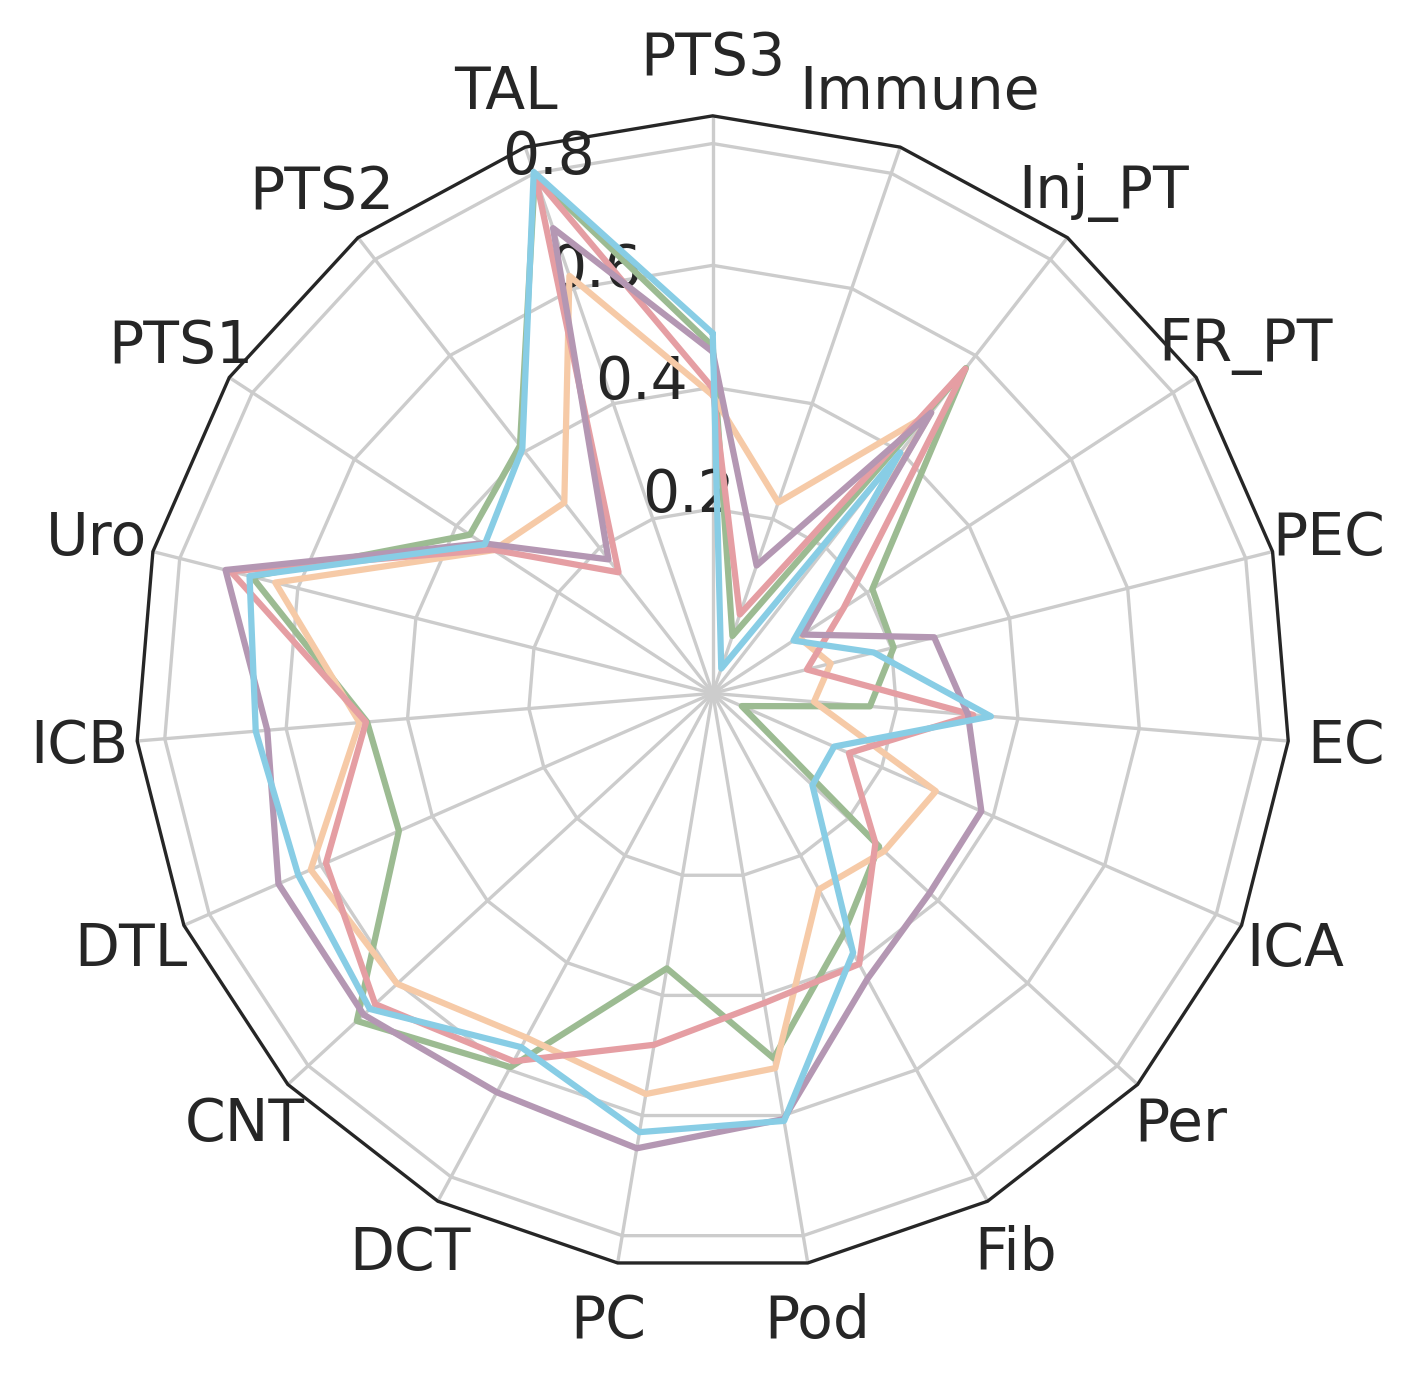

Day2R


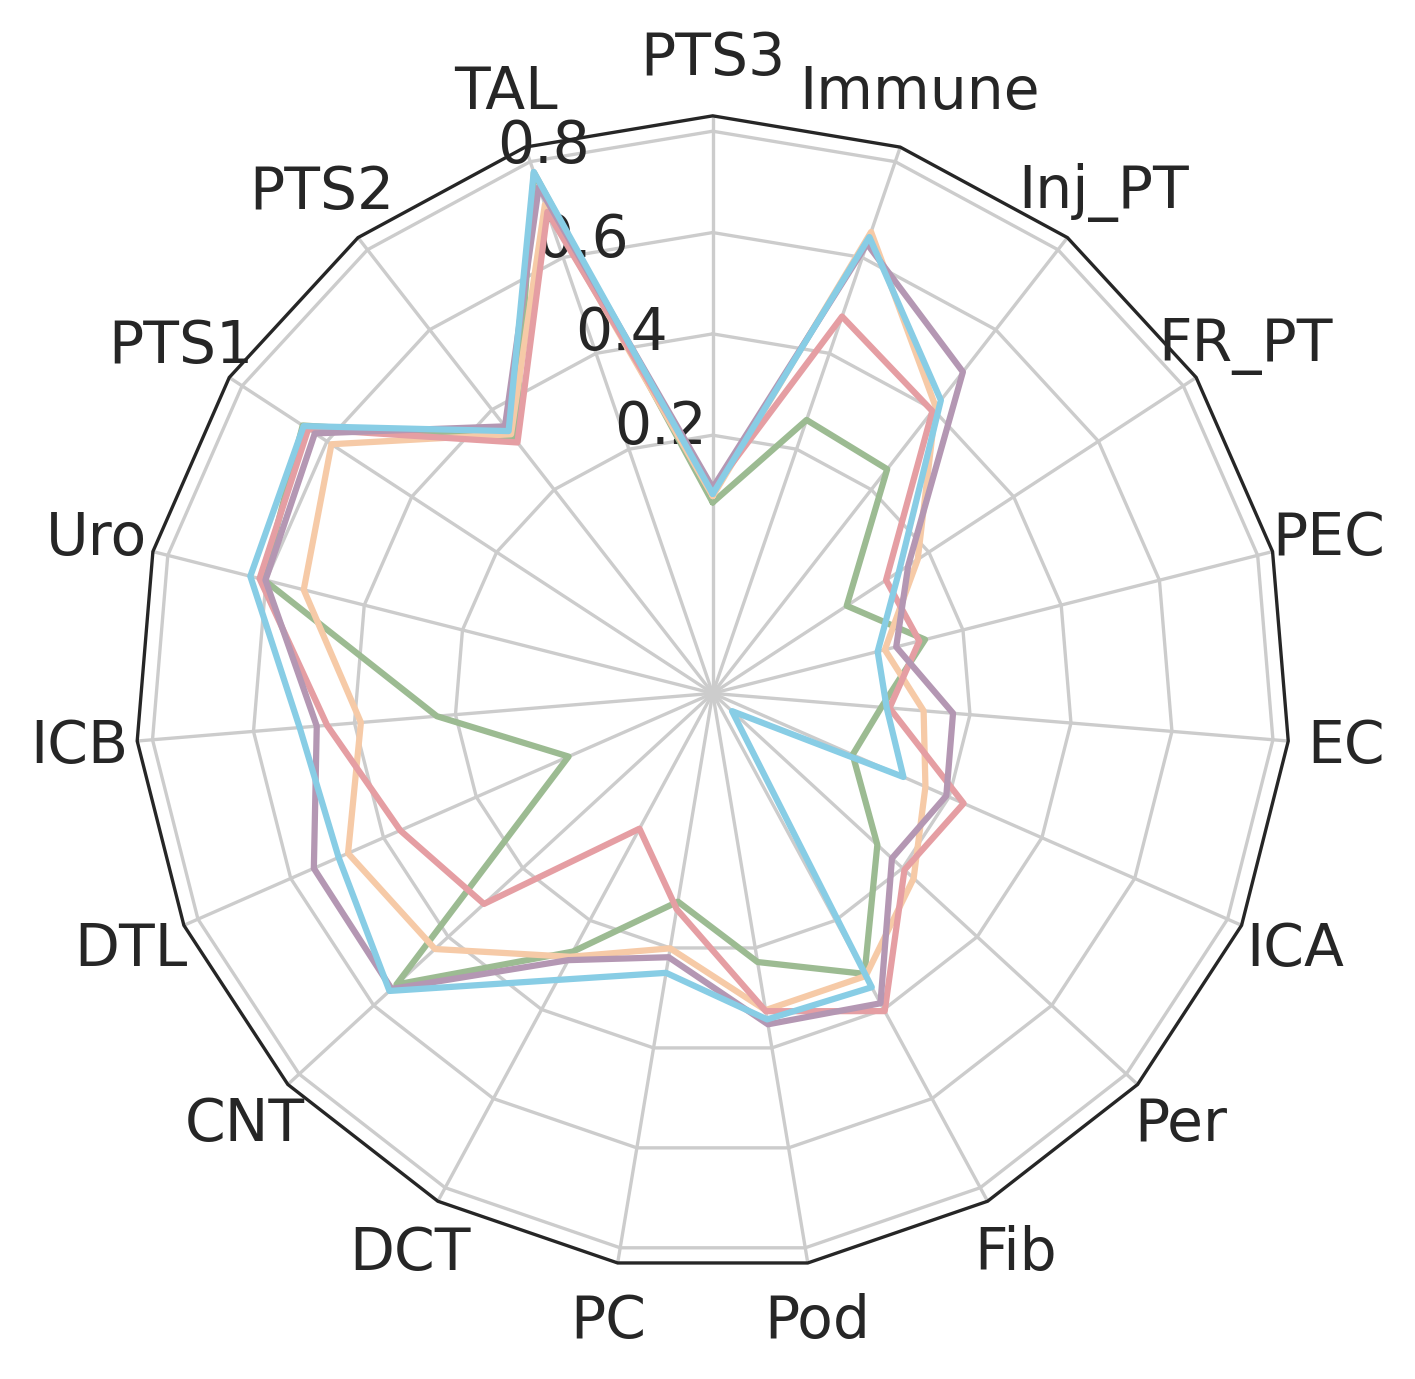

Day14R


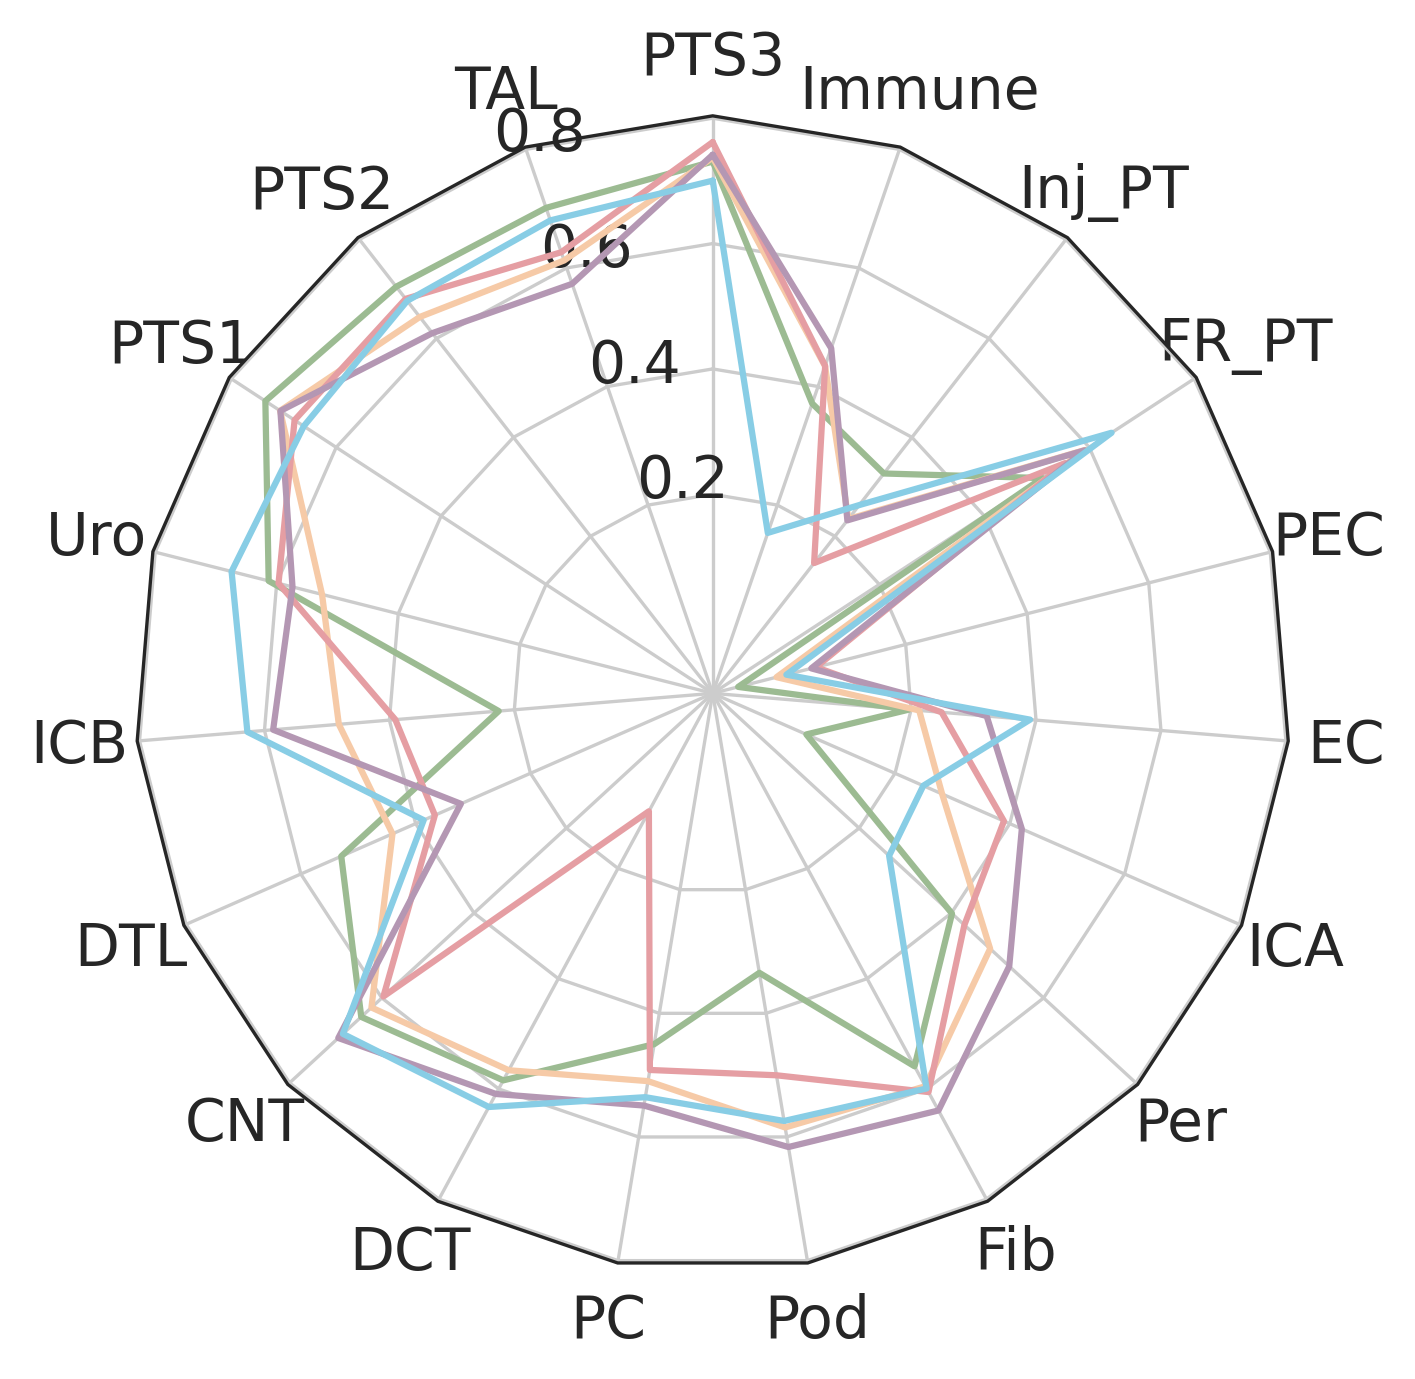

Week6R


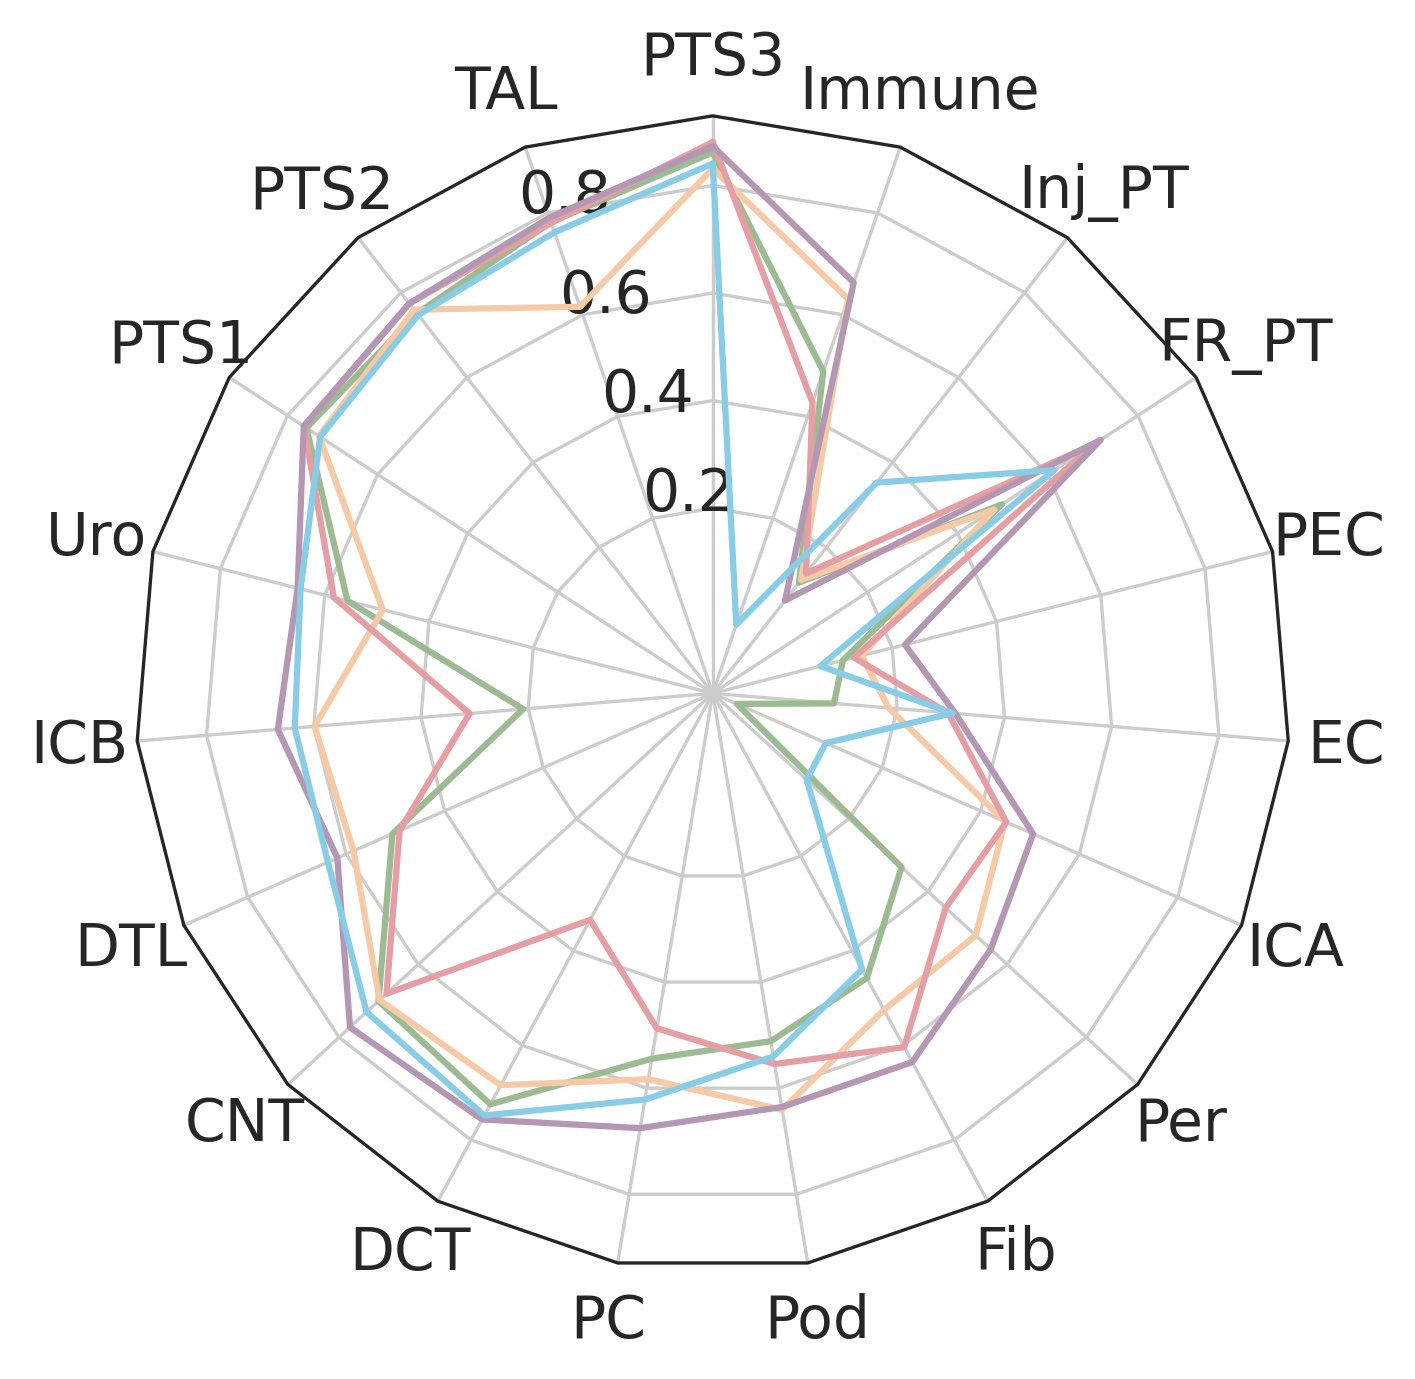

In [186]:
plt.rcParams.update({'font.size': 14}) 

for ident in ident_list:
    print(ident)
    plot_df = result_dict[ident]
    plot_df = plot_df.loc[celltype_order,]
    theta = radar_factory(len(celltype_order), frame='polygon')

    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection='radar'), dpi = 300)
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    
    for idx, (col, color) in enumerate(zip(plot_df.columns, hex_colors)):
        data = plot_df[col].values
        ax.plot(theta, data, label=col, color=color)
    
    ax.set_varlabels(celltype_order)
    plt.savefig(f"Deconv_pcc_{ident}.png", transparent=True, bbox_inches="tight")
    plt.show()

In [105]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):

    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta